In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt



import json
import requests
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import isnan
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.functions import expr
from pyspark.sql.functions import dayofmonth, month, hour, minute, dayofweek
from pyspark.sql.functions import isnan, isnull, sum
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import IntegerType, FloatType


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
taxi_zones = pd.read_csv("taxi_zones.csv")

In [3]:
taxi_zones.shape

(263, 7)

In [4]:
taxi_zones

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island
...,...,...,...,...,...,...,...
258,256,0.067915,MULTIPOLYGON (((-73.95834207500002 40.71330630...,0.000169,Williamsburg (South Side),256,Brooklyn
259,259,0.126750,MULTIPOLYGON (((-73.85107116191898 40.91037152...,0.000395,Woodlawn/Wakefield,259,Bronx
260,260,0.133514,MULTIPOLYGON (((-73.90175373399988 40.76077547...,0.000422,Woodside,260,Queens
261,261,0.027120,MULTIPOLYGON (((-74.01332610899988 40.70503078...,0.000034,World Trade Center,261,Manhattan


In [5]:
manhattan = taxi_zones[taxi_zones["borough"] == "Manhattan"]

In [6]:
manhattan.shape

(69, 7)

In [7]:
location_id = manhattan["LocationID"].tolist()

zone = manhattan["zone"].tolist()

manhattan_zones = dict(zip(location_id, zone))

In [8]:
len(manhattan_zones)

67

In [9]:
manhattan_zones

{4: 'Alphabet City',
 24: 'Bloomingdale',
 12: 'Battery Park',
 13: 'Battery Park City',
 41: 'Central Harlem',
 45: 'Chinatown',
 42: 'Central Harlem North',
 43: 'Central Park',
 48: 'Clinton East',
 50: 'Clinton West',
 68: 'East Chelsea',
 79: 'East Village',
 74: 'East Harlem North',
 75: 'East Harlem South',
 87: 'Financial District North',
 88: 'Financial District South',
 90: 'Flatiron',
 125: 'Hudson Sq',
 100: 'Garment District',
 103: "Governor's Island/Ellis Island/Liberty Island",
 107: 'Gramercy',
 113: 'Greenwich Village North',
 114: 'Greenwich Village South',
 116: 'Hamilton Heights',
 120: 'Highbridge Park',
 127: 'Inwood',
 128: 'Inwood Hill Park',
 151: 'Manhattan Valley',
 140: 'Lenox Hill East',
 137: 'Kips Bay',
 141: 'Lenox Hill West',
 142: 'Lincoln Square East',
 152: 'Manhattanville',
 143: 'Lincoln Square West',
 144: 'Little Italy/NoLiTa',
 148: 'Lower East Side',
 153: 'Marble Hill',
 158: 'Meatpacking/West Village West',
 161: 'Midtown Center',
 162: 'Mid

### Loading Taxi Data

In [10]:
spark = SparkSession.builder.appName("YourAppName").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", "10000")

# Reading CSV file into a DataFrame

taxi17 = spark.read.csv("taxi2017.csv", header=True)




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/29 14:46:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/29 14:46:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [11]:
#Displaying taxi dataframe
taxi17.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2|06/28/2017 07:48:...| 06/28/2017 08:03:...|              1|         2.02|         1|                 N|         249|         224|           1|         11|    1|    0.5|       1.2|           0|                  0.3|          14|
|       2|06/28/2017 07:48:...| 06/28/2017 08:01

In [12]:
taxi17.count()

113496874

In [13]:
manhattan_ids = list(manhattan_zones.keys())

In [14]:
#Filtering pickup and dropoff location if either is in manhattan

taxi17 = taxi17.filter((col("PULocationID").isin(manhattan_ids)) | (col("DOLocationID").isin(manhattan_ids)))

In [15]:
#Length of each dataset after filtration

print("Taxi17: ", taxi17.count())

Taxi17:  107689785


### Converting Features to Correct Datatype

- All features seem to be documented as string. I would be converting all features to the correct datatype

- That is strings would remain as strings, ints as ints etc.

In [16]:
print(taxi17.dtypes)


[('VendorID', 'string'), ('tpep_pickup_datetime', 'string'), ('tpep_dropoff_datetime', 'string'), ('passenger_count', 'string'), ('trip_distance', 'string'), ('RatecodeID', 'string'), ('store_and_fwd_flag', 'string'), ('PULocationID', 'string'), ('DOLocationID', 'string'), ('payment_type', 'string'), ('fare_amount', 'string'), ('extra', 'string'), ('mta_tax', 'string'), ('tip_amount', 'string'), ('tolls_amount', 'string'), ('improvement_surcharge', 'string'), ('total_amount', 'string')]


In [17]:
float_columns = ['trip_distance', 'fare_amount', 'mta_tax', 'tip_amount','tolls_amount', 'improvement_surcharge', 'total_amount']

date_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

int_columns = ['passenger_count']

category_columns = ['VendorID', 'RatecodeID', 'Store_and_fwd_flag', 'payment_type',  ]

In [18]:
for column in taxi17.columns:
    if column in float_columns: 
        taxi17 = taxi17.withColumn(column, col(column).cast('float'))
    elif column in date_columns:
        taxi17= taxi17.withColumn(column, to_timestamp(column, "MM/dd/yyyy hh:mm:ss a"))
    
    elif column in int_columns:
        taxi17 = taxi17.withColumn(column, col(column).cast('int'))
    
    else:
        taxi17 = taxi17.withColumn(column, col(column).cast(StringType()))
        
        
    

In [19]:
print(taxi17.dtypes)


[('VendorID', 'string'), ('tpep_pickup_datetime', 'timestamp'), ('tpep_dropoff_datetime', 'timestamp'), ('passenger_count', 'int'), ('trip_distance', 'float'), ('RatecodeID', 'string'), ('store_and_fwd_flag', 'string'), ('PULocationID', 'string'), ('DOLocationID', 'string'), ('payment_type', 'string'), ('fare_amount', 'float'), ('extra', 'string'), ('mta_tax', 'float'), ('tip_amount', 'float'), ('tolls_amount', 'float'), ('improvement_surcharge', 'float'), ('total_amount', 'float')]


### Handling Missing Values

In [20]:

missing_sum = taxi17.select([
    sum(isnull(col(column)).cast("integer")).alias(column + "_isNull") for column in taxi17.columns
] + [
    sum(isnan(col(column)).cast("integer")).alias(column + "_isNaN") for c in taxi17.columns
])

missing_sum.show()


+---------------+---------------------------+----------------------------+----------------------+--------------------+-----------------+-------------------------+-------------------+-------------------+-------------------+------------------+------------+--------------+-----------------+-------------------+----------------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|VendorID_isNull|tpep_pickup_datetime_isNull|tpep_dropoff_datetime_isNull|passenger_count_isNull|trip_distance_isNull|RatecodeID_isNull|store_and_fwd_flag_isNull|PULocationID_isNull|DOLocationID_isNull|payment_type_isNull|fare_amount_isNull|extra_isNull|mta_tax_isNull|tip_amount_isNull|tolls_amount_isNull|improvement_s

In [21]:
#Searching for missing values across each column
for column in taxi17.columns:
    missing_count = taxi17.filter(col(column).isNull() | 
                                  (col(column) == '') | 
                                  (col(column).contains('Na%')) | (col(column).contains('na%'))).count()
    print(f"{column}, number of missing values is {missing_count}")
    

VendorID, number of missing values is 0


tpep_pickup_datetime, number of missing values is 0


tpep_dropoff_datetime, number of missing values is 0


passenger_count, number of missing values is 0


trip_distance, number of missing values is 0


RatecodeID, number of missing values is 0


store_and_fwd_flag, number of missing values is 0


PULocationID, number of missing values is 0


DOLocationID, number of missing values is 0


payment_type, number of missing values is 0


fare_amount, number of missing values is 0


extra, number of missing values is 0


mta_tax, number of missing values is 0


tip_amount, number of missing values is 0


tolls_amount, number of missing values is 0


improvement_surcharge, number of missing values is 0


total_amount, number of missing values is 0


#### Observations
---------------------------------------

- As observed above, there seems to be 0 missing values in the dataset. This remains true even after adjusting the code to accomodate empty strings

 ### Logical Integrity Test and Handling Violations
 
 - 1. Taxis with no passengers
 
 - 2. Dropoff time should not be before pickup time
 
 - 3. Check if pickup or drop off date is before or after the dataset year (i.e 2017 or 2018)

#### Taxi Trips With no Passengers

In [22]:
print("Total rows where taxi had no passengers = ", taxi17.filter(col('passenger_count') == 0).count())

Total rows where taxi had no passengers =  146635


In [23]:
taxi17 = taxi17.filter(col('passenger_count') > 0)

In [24]:
print("Total rows where taxi had no passengers = ", taxi17.filter(col('passenger_count') == 0).count())

Total rows where taxi had no passengers =  0


 ####  Dropoff time before pickup time

In [25]:
#Count number of rows where dropoff was before pickup

print("Number of rows in violation = ", 
      taxi17.filter(col("tpep_dropoff_datetime") < col("tpep_pickup_datetime")).count())


Number of rows in violation =  4726


In [26]:
#Trying to see some of the rows violating this to make sure
taxi17.filter(col("tpep_dropoff_datetime") < col("tpep_pickup_datetime")).show(truncate = False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|1       |2017-07-19 15:15:01 |2017-07-16 16:00:15  |1              |7.3          |1         |Y                 |163         |138         |2           |26.5       |1    |0.5    |0.0       |0.0         |0.3                  |28.3        |
|1       |2017-07-22 15:15:12 |1997-07-22 15:30:

In [27]:
#Filtering out rows where dropoff is after pickup
taxi17 = taxi17.filter(col("tpep_dropoff_datetime") > col("tpep_pickup_datetime"))

In [28]:
#Count number of rows where dropoff was before pickup

print("Number of rows in violation = ", 
      taxi17.filter(col("tpep_dropoff_datetime") < col("tpep_pickup_datetime")).count())


Number of rows in violation =  0


#### 2.1. Rows where pickup, dropoff or both are after the dataset year

In [29]:
#Printing total number of pick-up time over 2018 
pickup_after_2017 = taxi17.filter(col("tpep_pickup_datetime") > "2017-12-31 23:59:59").count()

print("Total number of pickup dates after 2017= ", pickup_after_2017)

Total number of pickup dates after 2017=  49


In [30]:
#Printing total number of dropoff time over 2018
dropoff_after_2017 = taxi17.filter(col("tpep_dropoff_datetime") > "2017-12-31 23:59:59").count()

print("Total number of dropoff dates after 2017= ", dropoff_after_2017)

Total number of dropoff dates after 2017=  1549


In [31]:
#prints number of rows where pickup is 2018 and dropff is after 2018
#Assumption some of the post 2018 dropoff might be 
print("number of rows where pickup is 2017 and dropoff is after 2018: ",
      taxi17.filter((col("tpep_pickup_datetime") < "2017-12-31 23:59:59") & 
                    (col("tpep_dropoff_datetime") > "2017-12-31 23:59:59")).count())



number of rows where pickup is 2017 and dropoff is after 2018:  1500


In [32]:
#Prints Total number of rows where both pickup and dropoff time is after 2017
print("Total rows pickup and dropoff after 2017 :", 
      taxi17.filter((col("tpep_pickup_datetime") > "2017-12-31 23:59:59") 
                    & (col("tpep_dropoff_datetime") > "2017-12-31 23:59:59")).count())



Total rows pickup and dropoff after 2017 : 49


In [33]:
#filtering out rows where both pick up and dropoff after 2018
taxi17 = taxi17.filter(~((col("tpep_pickup_datetime") > "2017-12-31 23:59:59") & 
                         (col("tpep_dropoff_datetime") > "2017-12-31 23:59:59")))


In [34]:
#Prints Total number of rows where both pickup and dropoff time is after 2018
print("Total rows pickup and dropoff after 2017 :", 
      taxi17.filter((col("tpep_pickup_datetime") > "2017-12-31 23:59:59") 
                    & (col("tpep_dropoff_datetime") > "2017-12-31 23:59:59")).count())



Total rows pickup and dropoff after 2017 : 0


#### 2.2. Rows where pickup, dropoff or both are before the dataset year

In [35]:
dropoff_before2017= taxi17.filter(col("tpep_dropoff_datetime") < "2017-01-01 00:00:00").count()
print(" Total number of rows where dropoff was before 2017: ", dropoff_before2017)

 Total number of rows where dropoff was before 2017:  101


In [36]:
pickup_before2017= taxi17.filter(col("tpep_pickup_datetime") < "2017-01-01 00:00:00").count()
print(" Total number of rows where pickup was before 2017: ", pickup_before2017)

 Total number of rows where pickup was before 2017:  101


In [37]:
print("Total number of pickup or dropoff dates less 2017= ", 
      taxi17.filter((col("tpep_pickup_datetime") < "2017-01-01 00:00:00") | 
                    (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")).count())



Total number of pickup or dropoff dates less 2017=  101


In [38]:
print("Total number of pickup and dropoff dates less 2017= ", 
      taxi17.filter((col("tpep_pickup_datetime") > "2017-01-01 00:00:00") & 
                    (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")).count())



Total number of pickup and dropoff dates less 2017=  0


In [39]:
print("Total number of pickup and dropoff dates less 2017= ", 
      taxi17.filter((col("tpep_pickup_datetime") < "2017-01-01 00:00:00") & 
                    (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")).count())



Total number of pickup and dropoff dates less 2017=  101


In [40]:
filtered_df = taxi17.filter(
    (col("tpep_pickup_datetime") < "2017-01-01 00:00:00") &
    (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")
)

# Display the filtered DataFrame in descending order
filtered_df.orderBy(col("tpep_pickup_datetime").desc(), col("tpep_dropoff_datetime").desc()).show(truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|2       |2009-01-01 23:48:55 |2009-01-02 00:06:08  |1              |1.97         |1         |N                 |50          |246         |2           |10.0       |0    |0.5    |0.0       |0.0         |0.3                  |10.8        |
|2       |2009-01-01 21:22:35 |2009-01-01 21:58:

In [41]:
taxi17.filter((col("tpep_pickup_datetime") < "2017-01-01 00:00:00") & 
              (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")).show(truncate = False)



+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|2       |2008-12-31 23:34:04 |2008-12-31 23:39:41  |1              |0.93         |1         |N                 |237         |140         |2           |5.5        |0    |0.5    |0.0       |0.0         |0.3                  |6.3         |
|2       |2009-01-01 00:22:33 |2009-01-01 00:43:

In [42]:
#filtering out rows where both pick up and dropoff before 2017
taxi17 = taxi17.filter(~((col("tpep_pickup_datetime") < "2017-01-01 00:00:00") 
                         & (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")))


In [43]:
print("Total number of pickup and dropoff dates less 2017= ", 
      taxi17.filter((col("tpep_pickup_datetime") < "2017-01-01 00:00:00") & 
                    (col("tpep_dropoff_datetime") < "2017-01-01 00:00:00")).count())



Total number of pickup and dropoff dates less 2017=  0


### Excessively high Charges

In [44]:

print("Number of rows where fare is over 190 = ", taxi17.filter((col("total_amount") > 190)).count())

Number of rows where fare is over 190 =  4801


In [45]:
taxi17 = taxi17.filter(~(col("total_amount") > 190))

In [46]:

print("Number of rows where fare is over 190 = ", taxi17.filter((col("total_amount") > 190)).count())

Number of rows where fare is over 190 =  0


#### Long Trip distances

In [47]:
print("number of rows over 50 miles = ", taxi17.filter(col("trip_distance") > 50).count())

number of rows over 50 miles =  694


In [48]:
taxi17 = taxi17.filter(~(col("trip_distance") > 50))

In [49]:
print("number of rows over 50 miles = ", taxi17.filter(col("trip_distance") > 50).count())

number of rows over 50 miles =  0


### New Test For features where trip duration is longer than normal

In [50]:

print("Number of rows with pickup to drop-off duration over 2 hours: ", taxi17.filter(
     
    (expr("(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) > (2 * 3600)"))
).count())



Number of rows with pickup to drop-off duration over 2 hours:  190173


In [51]:
taxi17 = taxi17.filter(    
   ~ (expr("(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) > (2 * 3600)"))
)


In [52]:

print("Number of rows with pickup to drop-off duration over 2 hours: ", taxi17.filter(
     
    (expr("(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) > (2 * 3600)"))
).count())



Number of rows with pickup to drop-off duration over 2 hours:  0


#### Checking Features For Correlation

In [53]:
from pyspark.sql.types import IntegerType, FloatType

# Select the numerical columns for analysis
numerical_columns = [column for column in taxi17.columns
                     if isinstance(taxi17.schema[column].dataType, IntegerType)
                     or isinstance(taxi17.schema[column].dataType, FloatType)]

print(numerical_columns)


['passenger_count', 'trip_distance', 'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


In [54]:

# Create a vector assembler to combine the numerical columns into a single feature vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
feature_vector = assembler.transform(taxi17).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(feature_vector, "features")

# Extract the correlation matrix values
correlation_values = correlation_matrix.head()[0].toArray()

# Display the correlation matrix
for i in range(len(numerical_columns)):
    for j in range(len(numerical_columns)):
        print(f"Correlation between {numerical_columns[i]} and {numerical_columns[j]}: {correlation_values[i][j]}")


23/06/29 15:45:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/29 15:45:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Correlation between passenger_count and passenger_count: 1.0
Correlation between passenger_count and trip_distance: 0.016128080298881003
Correlation between passenger_count and fare_amount: 0.014171184247359817
Correlation between passenger_count and mta_tax: -0.0007079986195190871
Correlation between passenger_count and tip_amount: -0.0034291741053905102
Correlation between passenger_count and tolls_amount: 0.010847964480668566
Correlation between passenger_count and improvement_surcharge: -0.004517174583476371
Correlation between passenger_count and total_amount: 0.012020485479017054
Correlation between trip_distance and passenger_count: 0.016128080298881003
Correlation between trip_distance and trip_distance: 1.0
Correlation between trip_distance and fare_amount: 0.9369277869171271
Correlation between trip_distance and mta_tax: -0.11472079822629337
Correlation between trip_distance and tip_amount: 0.5868241207479075
Correlation between trip_distance and tolls_amount: 0.6596735614460

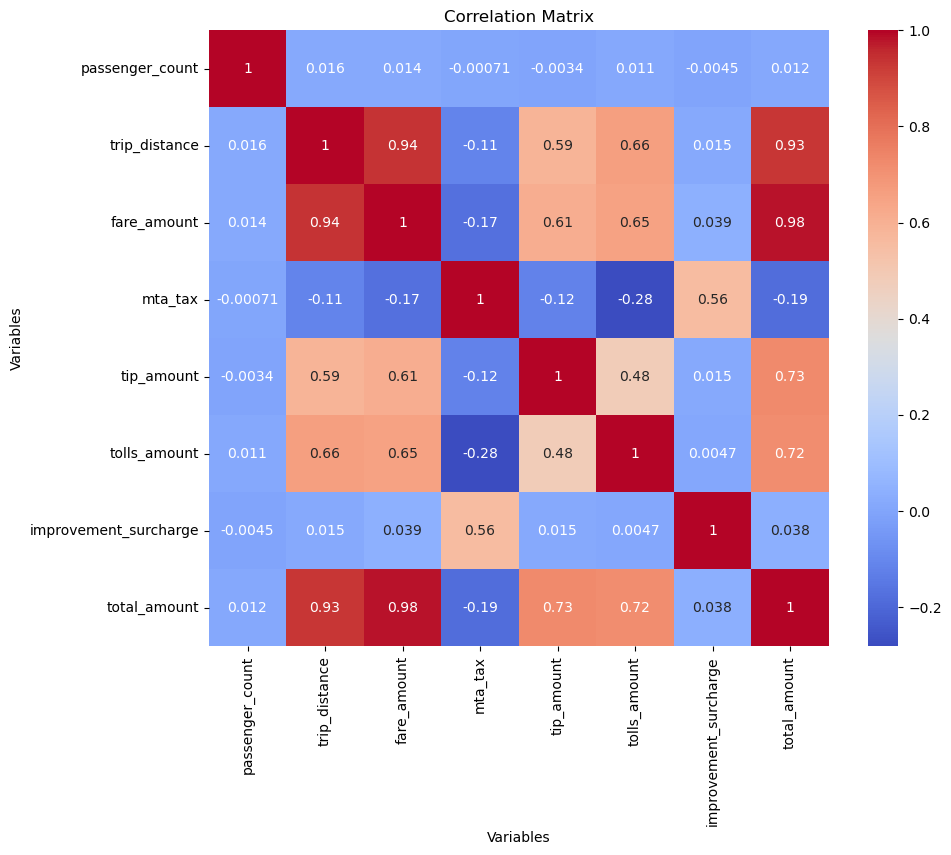

In [61]:
# Convert correlation values to a Pandas DataFrame
correlation_df = pd.DataFrame(correlation_values, columns=numerical_columns, index=numerical_columns)

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm")

# Set the plot title and labels
plt.title("Correlation Matrix")
plt.xlabel("Variables")
plt.ylabel("Variables")

# Display the plot
plt.show()


In [56]:
"""from pyspark.sql.functions import countDistinct

for column in taxi18.columns:
    distinct_count = taxi18.agg(countDistinct(column)).collect()[0][0]
    print("Total distinct values in column", column, "are:", distinct_count)
"""

'from pyspark.sql.functions import countDistinct\n\nfor column in taxi18.columns:\n    distinct_count = taxi18.agg(countDistinct(column)).collect()[0][0]\n    print("Total distinct values in column", column, "are:", distinct_count)\n'

### Adding New features

In [57]:
from pyspark.sql.functions import expr, round

taxi17 = taxi17.withColumn(
    'journey_length_in_minutes',
    round((expr("unix_timestamp(tpep_dropoff_datetime)") - expr("unix_timestamp(tpep_pickup_datetime)")) / 60, 2)
)

In [58]:
taxi17.select("tpep_pickup_datetime").distinct().orderBy(col("tpep_pickup_datetime").desc()).limit(100).show()

+--------------------+
|tpep_pickup_datetime|
+--------------------+
| 2017-12-31 23:59:56|
| 2017-12-31 23:59:50|
| 2017-12-31 23:59:49|
| 2017-12-31 23:59:47|
| 2017-12-31 23:59:46|
| 2017-12-31 23:59:44|
| 2017-12-31 23:59:43|
| 2017-12-31 23:59:42|
| 2017-12-31 23:59:40|
| 2017-12-31 23:59:37|
| 2017-12-31 23:59:36|
| 2017-12-31 23:59:35|
| 2017-12-31 23:59:32|
| 2017-12-31 23:59:30|
| 2017-12-31 23:59:29|
| 2017-12-31 23:59:23|
| 2017-12-31 23:59:22|
| 2017-12-31 23:59:19|
| 2017-12-31 23:59:17|
| 2017-12-31 23:59:16|
+--------------------+
only showing top 20 rows



In [59]:
"""taxi17 = taxi17.withColumn("pickup_day", dayofweek(col("tpep_pickup_datetime")))
taxi17 = taxi17.withColumn("pickup_month", month(col("tpep_pickup_datetime")))
taxi17 = taxi17.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
taxi17 = taxi17.withColumn("pickup_minute", minute(col("tpep_pickup_datetime")))"""

taxi17 = taxi17.withColumn("dropoff_day", dayofweek(col("tpep_dropoff_datetime")))
taxi17 = taxi17.withColumn("day_of_month", dayofmonth(col("tpep_dropoff_datetime")))
taxi17 = taxi17.withColumn("dropoff_month", month(col("tpep_dropoff_datetime")))
taxi17 = taxi17.withColumn("dropoff_hour", hour(col("tpep_dropoff_datetime")))
taxi17 = taxi17.withColumn("dropoff_minute", minute(col("tpep_dropoff_datetime")))
taxi17 = taxi17.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
taxi17 = taxi17.withColumn("pickup_minute", minute(col("tpep_pickup_datetime")))

In [60]:
distinct_days = taxi17.select("day_of_month").distinct()
distinct_days.show(31).sort()

+------------+
|day_of_month|
+------------+
|          28|
|          26|
|          27|
|           1|
|           6|
|           5|
|           4|
|           8|
|           7|
|          29|
|          30|
|          12|
|          13|
|           3|
|           9|
|          10|
|          11|
|           2|
|          15|
|          14|
|          16|
|          20|
|          19|
|          17|
|          18|
|          22|
|          23|
|          25|
|          24|
|          21|
|          31|
+------------+



AttributeError: 'NoneType' object has no attribute 'sort'

In [63]:
drop_features = ['extra','improvement_surcharge', 'total_amount']
taxi17.drop(*drop_features, inplace =)



DataFrame[VendorID: string, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: float, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: float, mta_tax: float, tip_amount: float, tolls_amount: float, journey_length_in_minutes: double, dropoff_day: int, day_of_month: int, dropoff_month: int, dropoff_hour: int, dropoff_minute: int, pickup_hour: int, pickup_minute: int]

In [64]:
taxi17.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'journey_length_in_minutes',
 'dropoff_day',
 'day_of_month',
 'dropoff_month',
 'dropoff_hour',
 'dropoff_minute',
 'pickup_hour',
 'pickup_minute']

In [ ]:
taxi17.coalesce(1).write.mode("overwrite").csv("taxi17_cleaned.csv", header=True)

